## Bollinguer Bands algo

1. Obtain candlestick data for a specific crypto.
2. The function would be passing a single crypto (or maybe an array?)
3. Perform algorithmic operations 
    - Price is passing top band 2 or 3 times (buy position)
    - Price is going below bottom band 2 or 3 times (sell position)

In [322]:
# libraries
import urllib.request as r
import json
import pandas as pd
import numpy as np
import matplotlib as plt
# candlestick
from mpl_finance import candlestick2_ochl
from mpl_finance import candlestick_ohlc
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

In [323]:
# Get data for a single crypto e.g. BTT in BNB market
base = 'https://api.binance.com'
ticker24 = '/api/v1/ticker/24hr'
candlestick = '/api/v1/klines'
params = '?symbol=BNBBTC&interval=1d'
# for Bollinger bands 20 day
bb_params = '?symbol=BTTBNB&interval=12h'
httpRes = r.urlopen(base + candlestick + params)
data = json.load(httpRes)

In [324]:
columns = ['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 'Quote asset volume', 'Number of trades','Taker buy base asset volume','Taker buy quote asset volume','ignore']
df = pd.DataFrame(data, columns=columns)
original_data = df;

## Function to parse data coming in

This only works if we are working with the same Json data.
This works if format matched 100%

In [325]:
# change default precision of decimals
pd.set_option("display.precision", 8)
# clean and parse data
dateFormat = '%d/%m/%Y'
# df.drop('ignore', axis=1, inplace=True)
df['Open time'] = pd.to_datetime(df['Open time'], unit='ms')
df['Close time'] = pd.to_datetime(df['Close time'], unit='ms')
df[['Open', 'High', 'Low', 'Close', 'Taker buy quote asset volume']] = df[['Open', 'High', 'Low', 'Close', 'Taker buy quote asset volume']].apply(lambda x: x.astype(float))
df[['Volume', 'Taker buy base asset volume']] = df[['Volume', 'Taker buy base asset volume']].apply(lambda x: x.astype(float))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
Open time                       500 non-null datetime64[ns]
Open                            500 non-null float64
High                            500 non-null float64
Low                             500 non-null float64
Close                           500 non-null float64
Volume                          500 non-null float64
Close time                      500 non-null datetime64[ns]
Quote asset volume              500 non-null object
Number of trades                500 non-null int64
Taker buy base asset volume     500 non-null float64
Taker buy quote asset volume    500 non-null float64
ignore                          500 non-null object
dtypes: datetime64[ns](2), float64(7), int64(1), object(2)
memory usage: 47.0+ KB


## Plotting candlestick

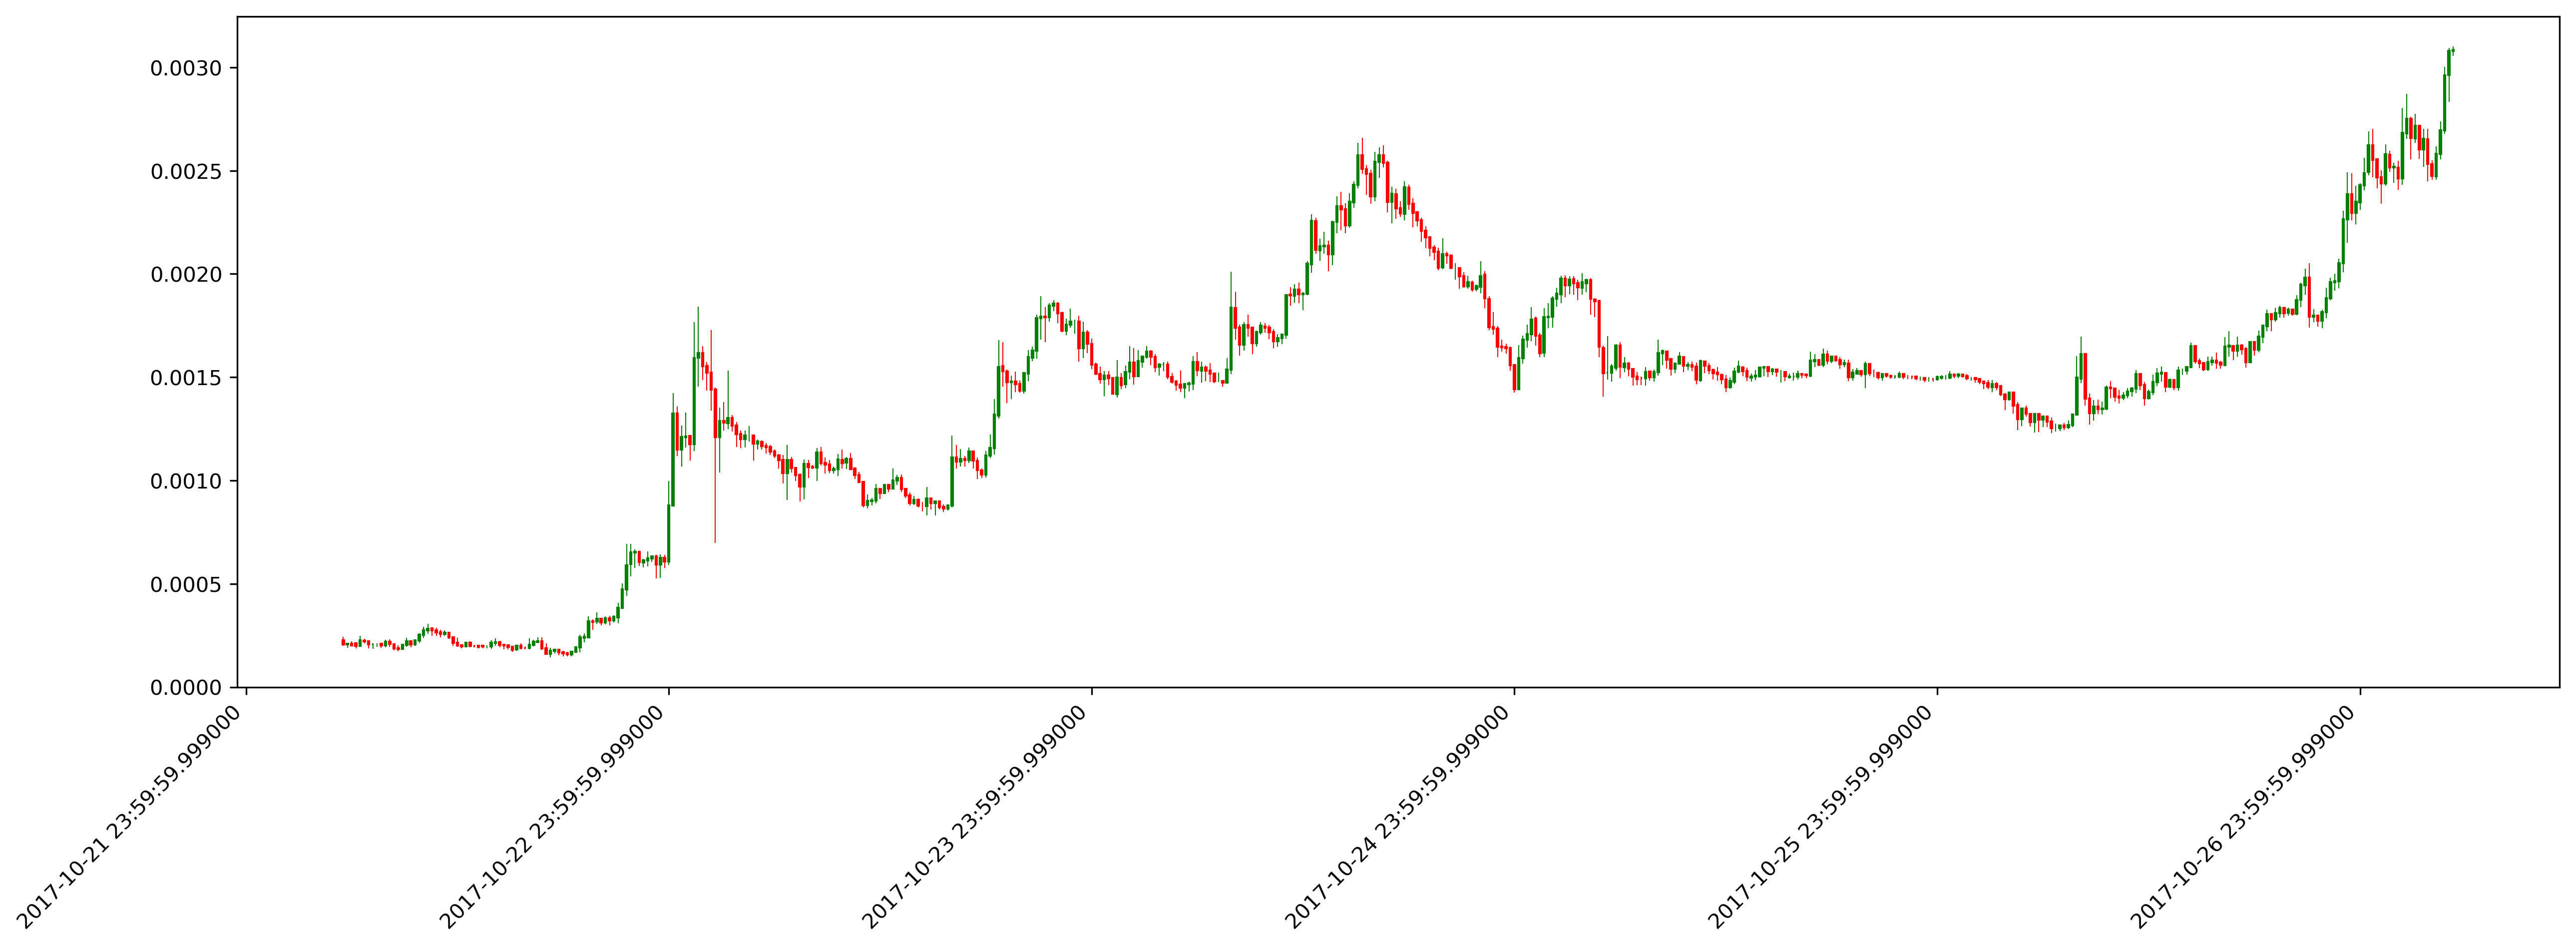

In [326]:
ohlc_df = df[['Open time', 'Open', 'High', 'Low', 'Close', 'Close time', 'Volume']]
quotes = zip(ohlc_df['Close time'].apply(mdates.date2num), ohlc_df['Open'], ohlc_df['High'], ohlc_df['Low'], ohlc_df['Close'])
fig = plt.figure(figsize=(20, 10), dpi=300)
ax = plt.subplot2grid((10, 5), (1, 0), rowspan=6, colspan=8)
candlestick_ohlc(ax, quotes, width=0.3, colorup='g')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d %H:%M'))
ax.set_xticklabels(ohlc_df['Close time'],rotation=45, horizontalalignment='right')
plt.show()

## Bollinguer bands + EWMA

In [390]:
# adding data
pd.options.mode.chained_assignment = None
ohlc_df['MA-30'] = pd.Series(ohlc_df['Close'].rolling(window=20).mean(), index=ohlc_df.index)
ohlc_df['Upper'] = pd.Series(ohlc_df['MA-30'] + 2*ohlc_df['Close'].rolling(window=20).std(), index=ohlc_df.index)
ohlc_df['Lower'] = pd.Series(ohlc_df['MA-30'] - 2*ohlc_df['Close'].rolling(window=20).std(), index=ohlc_df.index)

# signal line for MACD
ohlc_df['EWMA6'] = pd.Series(ohlc_df['Close'].ewm(span=6).mean(),  index=ohlc_df.index)
# Add Exponential Weighted MA
ohlc_df['EWMA12'] = pd.Series(ohlc_df['Close'].ewm(span=12).mean(),  index=ohlc_df.index)
ohlc_df['EWMA26'] = pd.Series(ohlc_df['Close'].ewm(span=26).mean(),  index=ohlc_df.index)
ohlc_df['MACD']= pd.Series(ohlc_df['EWMA26'] - ohlc_df['EWMA12'])
ohlc_df.dropna(inplace=True)
ohlc_df.head()

,Open time,Open,High,Low,Close,Close time,Volume,MA-30,Upper,Lower,EWMA12,EWMA26,MACD,EWMA6
114,2018-02-11,0.0010839,0.0011099,0.0010371,0.0010776,2018-02-11 23:59:59.999,2949767.66,0.00110943,0.00124135,0.00097750,0.00108199,0.00109215,0.00001016,0.00108036
115,2018-02-12,0.0010776,0.0010966,0.0010378,0.0010509,2018-02-12 23:59:59.999,1921666.18,0.00110110,0.00122511,0.00097709,0.00107706,0.00108834,0.00001128,0.00107194
116,2018-02-13,0.0010509,0.0010655,0.0010364,0.0010550,2018-02-13 23:59:59.999,1958685.89,0.00109297,0.00120559,0.00098034,0.00107358,0.00108531,0.00001173,0.00106709
117,2018-02-14,0.0010551,0.0011247,0.0010247,0.0011010,2018-02-14 23:59:59.999,2458900.79,0.00108903,0.00119412,0.00098393,0.00107789,0.00108671,0.00000882,0.00107679
118,2018-02-15,0.0010988,0.0011467,0.0010598,0.0010857,2018-02-15 23:59:59.999,2999856.03,0.00108394,0.00117829,0.00098959,0.00107911,0.00108662,0.00000751,0.00107933


### Plotting both candlestick and Bollinger

[Text(736500.0, 0, '2017-11-08 23:59:59.999000'),
 Text(736600.0, 0, '2017-11-09 23:59:59.999000'),
 Text(736700.0, 0, '2017-11-10 23:59:59.999000'),
 Text(736800.0, 0, '2017-11-11 23:59:59.999000'),
 Text(736900.0, 0, '2017-11-12 23:59:59.999000'),
 Text(737000.0, 0, '2017-11-13 23:59:59.999000')]

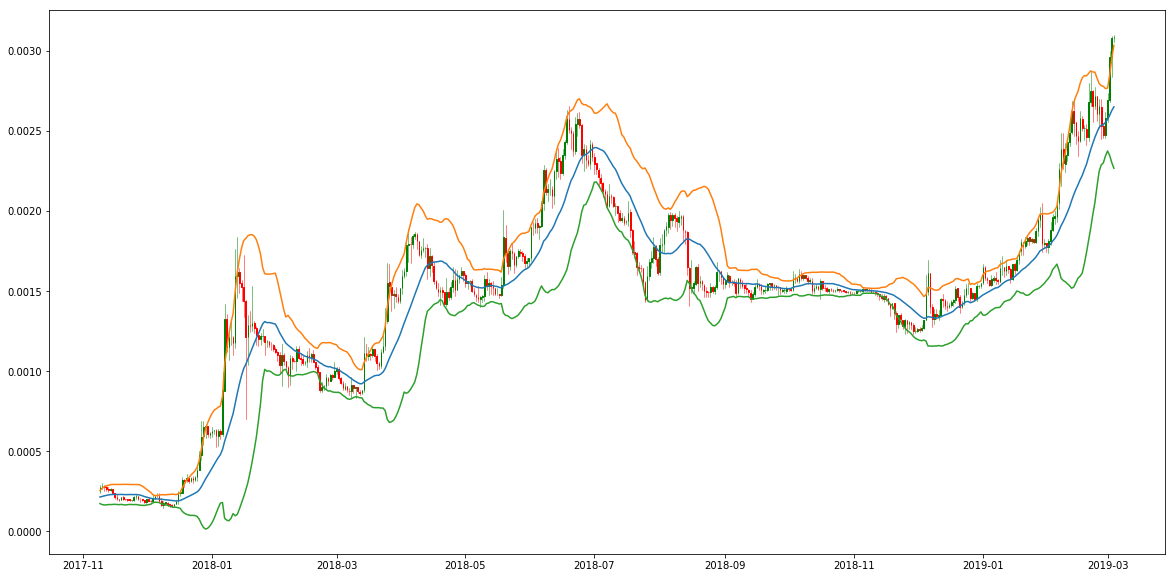

In [368]:
# plot config
# ohlc_df.head()
quotes = zip(ohlc_df['Close time'].apply(mdates.date2num), ohlc_df['Open'], ohlc_df['High'], ohlc_df['Low'], ohlc_df['Close'])
# Bollinguer
# fig = plt.figure(figsize=(20, 10), dpi=300)
# ax = plt.subplot2grid((10, 5), (1, 0), rowspan=6, colspan=8)
fig, ax1 = plt.subplots(figsize=(20,10))
candlestick_ohlc(ax1, quotes, width=0.3, colorup='g')
plt.plot(ohlc_df['Close time'], ohlc_df['MA-30'])
plt.plot(ohlc_df['Close time'], ohlc_df['Upper'])
plt.plot(ohlc_df['Close time'], ohlc_df['Lower'])
plt.plot(xlim=['2018-01-01', '2018-03-01'])
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d %H:%M'))
ax.set_xticklabels(ohlc_df['Close time'],rotation=45, horizontalalignment='right')

# plt.show()

### Fixing width to analyze certain parts of the plot

Use the line `plt.xlim` to fix dates for zoom in viewing

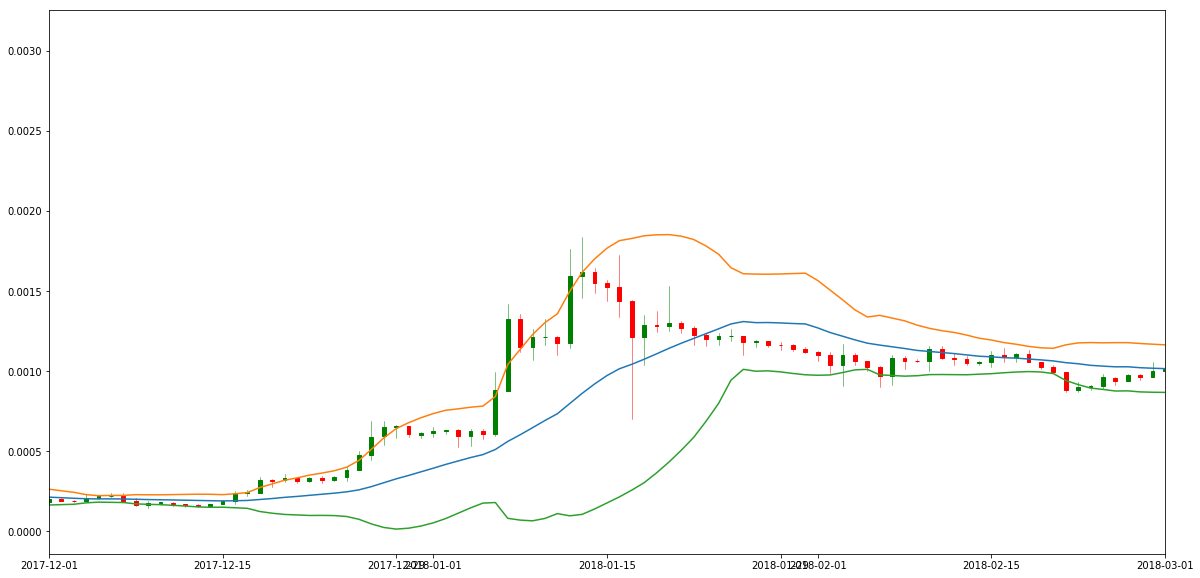

In [378]:
# plot config
# ohlc_df.head()
quotes = zip(ohlc_df['Close time'].apply(mdates.date2num), ohlc_df['Open'], ohlc_df['High'], ohlc_df['Low'], ohlc_df['Close'])
# Bollinguer
# fig = plt.figure(figsize=(20, 10), dpi=300)
# ax = plt.subplot2grid((10, 5), (1, 0), rowspan=6, colspan=8
fig, ax1 = plt.subplots(figsize=(20,10))
candlestick_ohlc(ax1, quotes, width=0.3, colorup='g')
plt.plot(ohlc_df['Close time'], ohlc_df['MA-30'])
plt.plot(ohlc_df['Close time'], ohlc_df['Upper'])
plt.plot(ohlc_df['Close time'], ohlc_df['Lower'])
# ohlc_df['Close time']
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d %H:%M'))
ax.set_xticklabels(ohlc_df['Close time'],rotation=45, horizontalalignment='right')

# set width here
plt.xlim('2017-12-01', '2018-03-01')
plt.show()